In [1]:
import datetime
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from datetime import date
from pyspark.sql.functions import sum, col, desc, asc, avg, stddev_samp, var_samp, round
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
import pandas as pd
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql.functions import udf

In [2]:
#Roda localmente, altere os caminhos para funcionar

source_file = '/home/otavio/Documentos/bd3/tabela_atualizada.csv'
target_file = '/home/otavio/Documentos/bd3/tabela_atualizada_utf8.csv'
source_file_2021 = '/home/otavio/Documentos/bd3/2021_04.csv'
target_file_2021 = '/home/otavio/Documentos/bd3/2021_04_utf8.csv'
source_file_2020 = '/home/otavio/Documentos/bd3/2020_04.csv'
target_file_2020 = '/home/otavio/Documentos/bd3/2020_04_utf8.csv'

In [3]:



with open(source_file, 'rb') as source:
    with open(target_file, 'w+b') as target:
        contents = source.read()
        target.write(contents.decode('utf-16').encode('utf-8'))

with open(target_file, encoding="utf8", errors='ignore') as f:
    contents = f.read()

array = contents.split('\n')
array.pop(0)

matriz = []
for linha in array:
    valor = linha.split(',')
    matriz.append(valor)


pandasDF = pd.DataFrame(matriz)


In [19]:

mySchema = StructType([StructField("regiao", StringType(), True),\
                       StructField("uf", StringType(), True),\
                       StructField("sexo", StringType(), True),\
                       StructField("idade", StringType(), True),\
                       StructField("categoria", StringType(), True),\
                       StructField("quantidade_condutor", StringType(), True)])

#Create PySpark SparkSession
spark = SparkSession.builder.getOrCreate()
#Create PySpark DataFrame from Pandas
sparkDF=spark.createDataFrame(pandasDF,schema=mySchema) 

sparkDF = sparkDF.withColumn("quantidade_condutor", sparkDF.quantidade_condutor.cast('integer'))
sparkDF = sparkDF.na.drop("any")

In [5]:
columns = ['regiao', 'sum(quantidade_condutor)']
total = sparkDF.groupBy().sum("quantidade_condutor").rdd.flatMap(lambda x: x).collect()
vals = [('Total', int(total[0]))]
totalRow = spark.createDataFrame(vals, columns)

df_soma_contudores = sparkDF\
        .groupBy("regiao")\
        .sum("quantidade_condutor")\
        .orderBy("sum(quantidade_condutor)")

df_soma_contudores = df_soma_contudores.union(totalRow)

df_soma_contudores =  df_soma_contudores\
        .withColumnRenamed("sum(quantidade_condutor)", "Quantidade de condutores")\
        .withColumnRenamed("regiao", "Região")\
        .show(truncate=False)

+------------+------------------------+
|Região      |Quantidade de condutores|
+------------+------------------------+
|Norte       |4044698                 |
|Centro-Oeste|7188875                 |
|Nordeste    |12090065                |
|Sul         |15225419                |
|Sudeste     |39368146                |
|Total       |77917203                |
+------------+------------------------+



<AxesSubplot:xlabel='Estados do sudeste'>

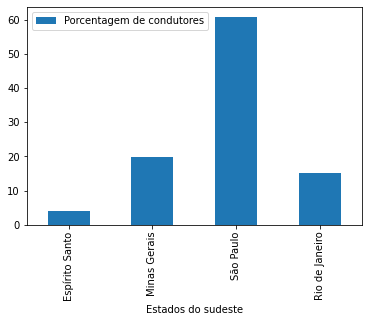

In [6]:
df_sudoeste = sparkDF\
        .filter(sparkDF.regiao == 'Sudeste')\
        .groupBy("uf")\
        .sum("quantidade_condutor")

data_sudoeste = df_sudoeste.select(col("sum(quantidade_condutor)")).rdd.flatMap(lambda x: x).collect()
index_sudoeste = df_sudoeste.select(col("uf")).rdd.flatMap(lambda x: x).collect()

soma_total = 0
for estado in data_sudoeste:
    soma_total += int(estado)

i = 0
while(i < len(data_sudoeste)):
    data_sudoeste[i] = data_sudoeste[i]/soma_total*100
    i += 1
    
df = pd.DataFrame({'Estados do sudeste': index_sudoeste, 'Porcentagem de condutores': data_sudoeste})
df.plot.bar(x='Estados do sudeste', y='Porcentagem de condutores') 

<AxesSubplot:ylabel='Categorias'>

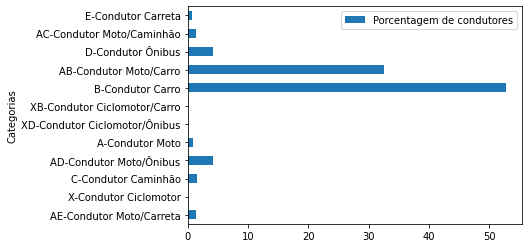

In [7]:
 df_categoria = sparkDF\
        .filter(sparkDF.uf == 'São Paulo')\
        .groupBy("categoria")\
        .sum("quantidade_condutor")

data_categoria = df_categoria.select(col("sum(quantidade_condutor)")).rdd.flatMap(lambda x: x).collect()
index_categoria = df_categoria.select(col("categoria")).rdd.flatMap(lambda x: x).collect()

soma_total = 0
for cat in data_categoria:
    soma_total += int(cat)

i = 0
while(i < len(data_categoria)):
    data_categoria[i] = data_categoria[i]/soma_total*100
    i += 1
    
df = pd.DataFrame({'Categorias': index_categoria, 'Porcentagem de condutores': data_categoria})
df.plot.barh(x='Categorias', y='Porcentagem de condutores') 

<AxesSubplot:ylabel='Categorias'>

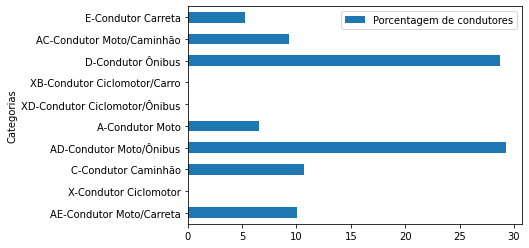

In [8]:
 df_categoria2 = sparkDF\
        .filter(sparkDF.uf == 'São Paulo')\
        .filter(sparkDF.categoria != 'AB-Condutor Moto/Carro')\
        .filter(sparkDF.categoria != 'B-Condutor Carro')\
        .groupBy("categoria")\
        .sum("quantidade_condutor")

data_categoria = df_categoria2.select(col("sum(quantidade_condutor)")).rdd.flatMap(lambda x: x).collect()
index_categoria = df_categoria2.select(col("categoria")).rdd.flatMap(lambda x: x).collect()

soma_total = 0
for cat in data_categoria:
    soma_total += int(cat)

i = 0
while(i < len(data_categoria)):
    data_categoria[i] = data_categoria[i]/soma_total*100
    i += 1

df = pd.DataFrame({'Categorias': index_categoria, 'Porcentagem de condutores': data_categoria})
df.plot.barh(x='Categorias', y='Porcentagem de condutores') 

In [9]:
df_categoria2.withColumnRenamed("sum(quantidade_condutor)", "Quantidade de condutores")\
             .show(truncate=False)

+-----------------------------+------------------------+
|categoria                    |Quantidade de condutores|
+-----------------------------+------------------------+
|AE-Condutor Moto/Carreta     |351623                  |
|X-Condutor Ciclomotor        |20                      |
|C-Condutor Caminhão          |376308                  |
|AD-Condutor Moto/Ônibus      |1027689                 |
|A-Condutor Moto              |229388                  |
|XD-Condutor Ciclomotor/Ônibus|1                       |
|XB-Condutor Ciclomotor/Carro |46                      |
|D-Condutor Ônibus            |1008561                 |
|AC-Condutor Moto/Caminhão    |326150                  |
|E-Condutor Carreta           |186491                  |
+-----------------------------+------------------------+



In [10]:
df_autoescola = sparkDF\
        .filter(sparkDF.uf == 'São Paulo')\
        .filter((sparkDF.categoria == 'AB-Condutor Moto/Carro') | (sparkDF.categoria == 'B-Condutor Carro') | (sparkDF.categoria == 'A-Condutor Moto'))\
        .groupBy("categoria","idade")\
        .sum("quantidade_condutor")\
        .withColumnRenamed("sum(quantidade_condutor)", "Quantidade de condutores")\
        .orderBy(col('Quantidade de condutores').desc())

df_autoescola.show(truncate=False, n=50)

+----------------------+-----------+------------------------+
|categoria             |idade      |Quantidade de condutores|
+----------------------+-----------+------------------------+
|B-Condutor Carro      |41 a 50    |2697761                 |
|B-Condutor Carro      |31 a 40    |2641717                 |
|AB-Condutor Moto/Carro|31 a 40    |2553415                 |
|B-Condutor Carro      |51 a 60    |2041401                 |
|B-Condutor Carro      |61 a 70    |1706868                 |
|AB-Condutor Moto/Carro|41 a 50    |1635021                 |
|AB-Condutor Moto/Carro|26 a 30    |1175647                 |
|B-Condutor Carro      |71 a 80    |1042247                 |
|B-Condutor Carro      |26 a 30    |1001247                 |
|AB-Condutor Moto/Carro|51 a 60    |795153                  |
|AB-Condutor Moto/Carro|22 a 25    |780704                  |
|B-Condutor Carro      |22 a 25    |617093                  |
|B-Condutor Carro      |81 a 90    |475762                  |
|AB-Cond

+--------+------------------------+
|   idade|Quantidade de condutores|
+--------+------------------------+
|91 a 100|                  178556|
| 81 a 90|                  508469|
| 71 a 80|                 1157518|
| 61 a 70|                 2052609|
| 51 a 60|                 2860204|
| 41 a 50|                 4378783|
| 31 a 40|                 5264076|
| 18 a 30|                 4246524|
+--------+------------------------+



<AxesSubplot:ylabel='Idades'>

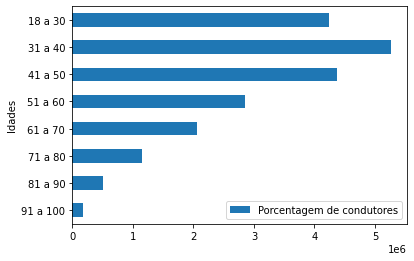

In [11]:
df_autoescola_idade = df_autoescola.groupBy("idade")\
        .sum("Quantidade de condutores")\
        .filter(df_autoescola.idade != 'Mais de 120')\
        .filter(df_autoescola.idade != '101 a 120')\
        .filter(df_autoescola.idade != '18 a 21')\
        .filter(df_autoescola.idade != '22 a 25')\
        .filter(df_autoescola.idade != '26 a 30')\
        .withColumnRenamed("sum(Quantidade de condutores)", "Quantidade de condutores")\
        .orderBy(col('idade').desc())

#juntando 18 a 21, 22 a 25 e 26 a 30
df_autoescola_idade_menor_30 = df_autoescola\
        .filter((df_autoescola.idade == '18 a 21')|(df_autoescola.idade == '22 a 25')|(df_autoescola.idade == '26 a 30'))\
        .groupBy()\
        .sum("Quantidade de condutores")\
        .withColumnRenamed("sum(Quantidade de condutores)", "Quantidade de condutores")

menor_30 = df_autoescola_idade_menor_30.select(col("Quantidade de condutores")).rdd.flatMap(lambda x: x).collect()
columns = ['idade', 'Quantidade de condutores']
vals = [('18 a 30', int(menor_30[0]))]
totalRow = spark.createDataFrame(vals, columns)

df_autoescola_idade = df_autoescola_idade.union(totalRow)
df_autoescola_idade.show()


data_idade = df_autoescola_idade.select(col("Quantidade de condutores")).rdd.flatMap(lambda x: x).collect()
index_idade = df_autoescola_idade.select(col("idade")).rdd.flatMap(lambda x: x).collect()


df = pd.DataFrame({'Idades': index_idade, 'Porcentagem de condutores': data_idade})
df.plot.barh(x='Idades', y='Porcentagem de condutores') 

In [12]:
df_2022 = sparkDF\
        .filter(sparkDF.uf == 'São Paulo')\
        .filter((sparkDF.categoria == 'AB-Condutor Moto/Carro') | (sparkDF.categoria == 'B-Condutor Carro'))\
        .filter(df_autoescola.idade == '31 a 40')\
        .groupBy("categoria","idade")\
        .sum("quantidade_condutor")\
        .withColumnRenamed("sum(quantidade_condutor)", "Quantidade de condutores")\
        

df_2022_2 = sparkDF\
        .filter(sparkDF.uf == 'São Paulo')\
        .filter((sparkDF.categoria == 'AB-Condutor Moto/Carro') | (sparkDF.categoria == 'B-Condutor Carro'))\
        .filter((df_autoescola.idade == '18 a 21')|(df_autoescola.idade == '22 a 25')|(df_autoescola.idade == '26 a 30'))\
        .groupBy("categoria")\
        .sum("quantidade_condutor")\
        .withColumnRenamed("sum(quantidade_condutor)", "Quantidade de condutores")\
        .orderBy(col('categoria'))
    
menor_30 = df_2022_2.select(col("Quantidade de condutores")).rdd.flatMap(lambda x: x).collect()
columns = ['categoria','idade', 'Quantidade de condutores']
vals1 = [('AB-Condutor Moto/Carro','18 a 30', int(menor_30[0]))]
vals2 = [('B-Condutor Carro','18 a 30', int(menor_30[1]))]
totalRow1 = spark.createDataFrame(vals1, columns)
totalRow2 = spark.createDataFrame(vals2, columns)

df_2022_res = df_2022.union(totalRow1)
df_2022_res = df_2022_res.union(totalRow2)


df_2022_res.orderBy(col('categoria'),col('idade')).show(truncate=False, n=50)

+----------------------+-------+------------------------+
|categoria             |idade  |Quantidade de condutores|
+----------------------+-------+------------------------+
|AB-Condutor Moto/Carro|18 a 30|2308384                 |
|AB-Condutor Moto/Carro|31 a 40|2553415                 |
|B-Condutor Carro      |18 a 30|1857986                 |
|B-Condutor Carro      |31 a 40|2641717                 |
+----------------------+-------+------------------------+



In [13]:
# 2020 ===============


with open(source_file_2020, 'rb') as source:
    with open(target_file_2020, 'w+b') as target:
        contents = source.read()
        target.write(contents.decode('utf-16').encode('utf-8'))

with open(target_file_2020, encoding="utf8", errors='ignore') as f:
    contents = f.read()

array = contents.split('\n')
array.pop(0)

matriz = []
for linha in array:
    valor = linha.split(',')
    matriz.append(valor)

def stripDQ(string):
    return string.replace('"', "").replace('.', "")
udf_stripDQ = udf(stripDQ, StringType())

pandasDF = pd.DataFrame(matriz)
df_2020 = spark.createDataFrame(pandasDF,schema=mySchema) 
df_2020 = df_2020.na.drop("any")
df_2020 = df_2020.withColumn("quantidade_condutor", udf_stripDQ(df_2020["quantidade_condutor"])).withColumn("uf", udf_stripDQ(df_2020["uf"])).withColumn("regiao", udf_stripDQ(df_2020["regiao"])).withColumn("sexo", udf_stripDQ(df_2020["sexo"])).withColumn("idade", udf_stripDQ(df_2020["idade"])).withColumn("categoria", udf_stripDQ(df_2020["categoria"]))
df_2020 = df_2020.withColumn("quantidade_condutor", df_2020.quantidade_condutor.cast('integer'))


In [14]:
df_2020_1 = df_2020\
        .filter(df_2020.uf == 'São Paulo')\
        .filter((df_2020.categoria == 'AB-Condutor Moto/Carro') | (df_2020.categoria == 'B-Condutor Carro'))\
        .filter(df_2020.idade == '31 a 40')\
        .groupBy("categoria","idade")\
        .sum("quantidade_condutor")\
        .withColumnRenamed("sum(quantidade_condutor)", "Quantidade de condutores")

df_2020_2 = df_2020\
        .filter(df_2020.uf == 'São Paulo')\
        .filter((df_2020.categoria == 'AB-Condutor Moto/Carro') | (df_2020.categoria == 'B-Condutor Carro'))\
        .filter((df_2020.idade == '18 a 21')|(df_2020.idade == '22 a 25')|(df_2020.idade == '26 a 30'))\
        .groupBy("categoria")\
        .sum("quantidade_condutor")\
        .withColumnRenamed("sum(quantidade_condutor)", "Quantidade de condutores")\
        .orderBy(col('categoria'))

menor_30 = df_2020_2.select(col("Quantidade de condutores")).rdd.flatMap(lambda x: x).collect()
columns = ['categoria','idade', 'Quantidade de condutores']
vals1 = [('AB-Condutor Moto/Carro','18 a 30', int(menor_30[0]))]
vals2 = [('B-Condutor Carro','18 a 30', int(menor_30[1]))]
totalRow1 = spark.createDataFrame(vals1, columns)
totalRow2 = spark.createDataFrame(vals2, columns)

df_2020_res = df_2020_1.union(totalRow1)
df_2020_res = df_2020_res.union(totalRow2)


df_2020_res.orderBy(col('categoria'),col('idade')).show(truncate=False, n=50)

+----------------------+-------+------------------------+
|categoria             |idade  |Quantidade de condutores|
+----------------------+-------+------------------------+
|AB-Condutor Moto/Carro|18 a 30|2409933                 |
|AB-Condutor Moto/Carro|31 a 40|2431260                 |
|B-Condutor Carro      |18 a 30|1990684                 |
|B-Condutor Carro      |31 a 40|2759295                 |
+----------------------+-------+------------------------+



In [15]:
# 2021 ===============


with open(source_file_2021, 'rb') as source:
    with open(target_file_2021, 'w+b') as target:
        contents = source.read()
        target.write(contents.decode('utf-16').encode('utf-8'))

with open(target_file_2021, encoding="utf8", errors='ignore') as f:
    contents = f.read()

array = contents.split('\n')
array.pop(0)

matriz = []
for linha in array:
    valor = linha.split(',')
    matriz.append(valor)

def stripDQ(string):
    return string.replace('"', "").replace('.', "")
udf_stripDQ = udf(stripDQ, StringType())

pandasDF = pd.DataFrame(matriz)
df_2021 = spark.createDataFrame(pandasDF,schema=mySchema) 
df_2021 = df_2021.na.drop("any")
df_2021 = df_2021.withColumn("quantidade_condutor", udf_stripDQ(df_2021["quantidade_condutor"])).withColumn("uf", udf_stripDQ(df_2021["uf"])).withColumn("regiao", udf_stripDQ(df_2021["regiao"])).withColumn("sexo", udf_stripDQ(df_2021["sexo"])).withColumn("idade", udf_stripDQ(df_2021["idade"])).withColumn("categoria", udf_stripDQ(df_2021["categoria"]))
df_2021 = df_2021.withColumn("quantidade_condutor", df_2021.quantidade_condutor.cast('integer'))

In [16]:
df_2021_1 = df_2021\
        .filter(df_2021.uf == 'São Paulo')\
        .filter((df_2021.categoria == 'AB-Condutor Moto/Carro') | (df_2021.categoria == 'B-Condutor Carro'))\
        .filter(df_2021.idade == '31 a 40')\
        .groupBy("categoria","idade")\
        .sum("quantidade_condutor")\
        .withColumnRenamed("sum(quantidade_condutor)", "Quantidade de condutores")

df_2021_2 = df_2021\
        .filter(df_2021.uf == 'São Paulo')\
        .filter((df_2021.categoria == 'AB-Condutor Moto/Carro') | (df_2021.categoria == 'B-Condutor Carro'))\
        .filter((df_2021.idade == '18 a 21')|(df_2021.idade == '22 a 25')|(df_2021.idade == '26 a 30'))\
        .groupBy("categoria")\
        .sum("quantidade_condutor")\
        .withColumnRenamed("sum(quantidade_condutor)", "Quantidade de condutores")\
        .orderBy(col('categoria'))

menor_30 = df_2021_2.select(col("Quantidade de condutores")).rdd.flatMap(lambda x: x).collect()
columns = ['categoria','idade', 'Quantidade de condutores']
vals1 = [('AB-Condutor Moto/Carro','18 a 30', int(menor_30[0]))]
vals2 = [('B-Condutor Carro','18 a 30', int(menor_30[1]))]
totalRow1 = spark.createDataFrame(vals1, columns)
totalRow2 = spark.createDataFrame(vals2, columns)

df_2021_res = df_2021_1.union(totalRow1)
df_2021_res = df_2021_res.union(totalRow2)


df_2021_res.orderBy(col('categoria'),col('idade')).show(truncate=False, n=50)

+----------------------+-------+------------------------+
|categoria             |idade  |Quantidade de condutores|
+----------------------+-------+------------------------+
|AB-Condutor Moto/Carro|18 a 30|2261155                 |
|AB-Condutor Moto/Carro|31 a 40|2487744                 |
|B-Condutor Carro      |18 a 30|1851710                 |
|B-Condutor Carro      |31 a 40|2690742                 |
+----------------------+-------+------------------------+



In [17]:
res2022 = df_2022_res.select(col("Quantidade de condutores")).rdd.flatMap(lambda x: x).collect()
res2021 = df_2021_res.select(col("Quantidade de condutores")).rdd.flatMap(lambda x: x).collect()
res2020 = df_2020_res.select(col("Quantidade de condutores")).rdd.flatMap(lambda x: x).collect()
index = ['2020','2021','2022']
categorias = [[res2020[0],res2021[0],res2022[0]],[res2020[1],res2021[1],res2022[1]],[res2020[2],res2021[2],res2022[2]],[res2020[3],res2021[3],res2022[3]]]

<AxesSubplot:>

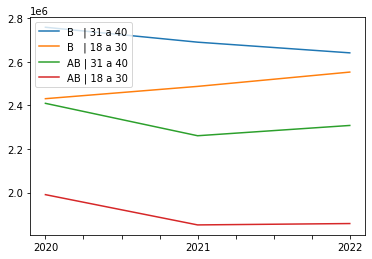

In [18]:
df = pd.DataFrame({'B   | 31 a 40': categorias[0],'B   | 18 a 30': categorias[1],'AB | 31 a 40': categorias[2],'AB | 18 a 30': categorias[3]},index = ['2020','2021','2022'])
df.plot.line() 